<h2> DQN Stock Agent <h2>


In [1]:
#This code is experimental. Might need revision.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [25]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [26]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.5]
Best error: 0.06359328008082799


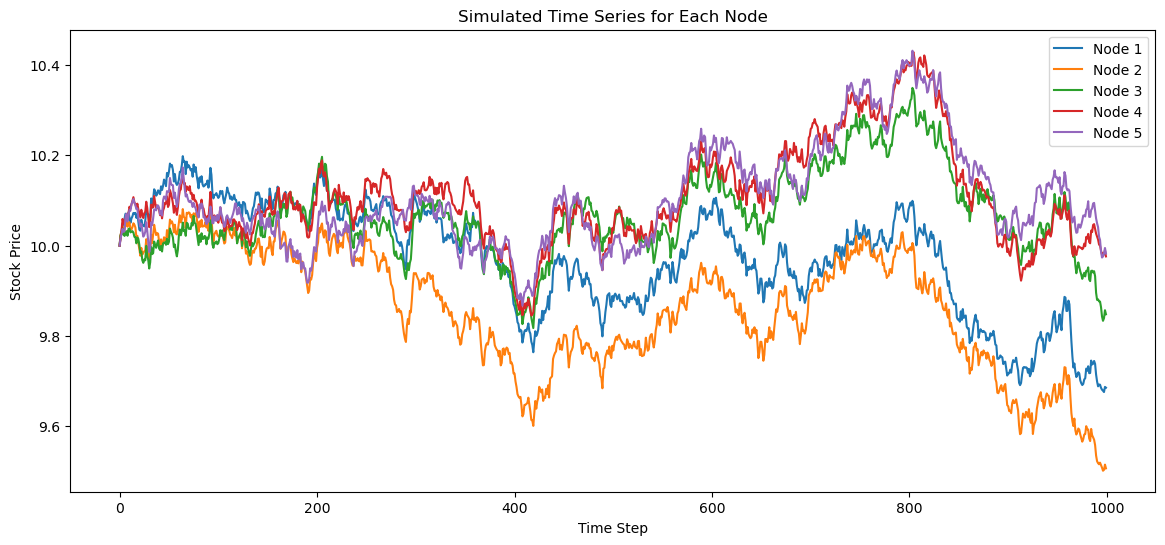

In [27]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

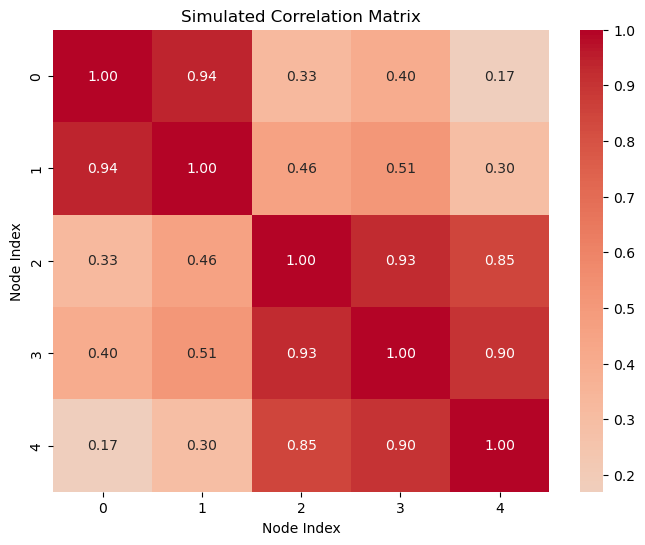

In [28]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [29]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

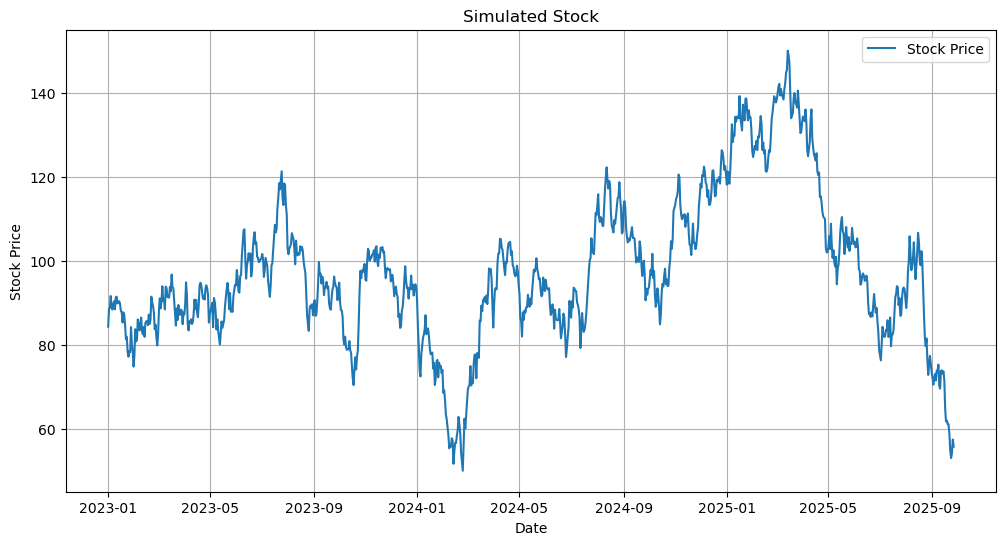

In [30]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
import numpy as np
import random
import pickle
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
tf.compat.v1.disable_eager_execution()

In [36]:
class StockTradingEnvironment:
    def __init__(self, stock_prices, transaction_fee=0.001):
        self.stock_prices = stock_prices
        self.transaction_fee = transaction_fee
        self.reset()

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.shares = 0
        print(f"Environment reset. Initial balance: {self.balance}, Shares: {self.shares}")
        return self.get_state()

    def get_state(self, window_size=5):
        start = max(0, self.current_step - window_size + 1)
        state = self.stock_prices[start:self.current_step + 1]
        state = np.pad(state, (window_size - len(state), 0), 'constant')
        return state

    def take_action(self, action):
        current_price = self.stock_prices[self.current_step]
        reward = 0
        action_str = ""
        
        if action == 0:  # Hold
            reward = 0.1 if self.current_step > 0 and current_price > self.stock_prices[self.current_step - 1] else -0.01
            action_str = "Hold"

        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price * (1 + self.transaction_fee)
                reward = -0.05
                action_str = "Buy"
            else:
                reward = -1  # Penalty for insufficient balance
                action_str = "Buy (Failed)"
        
        elif action == 2:  # Sell
            if self.shares > 0:
                sale_amount = current_price * (1 - self.transaction_fee)
                profit = sale_amount - (current_price * (1 + self.transaction_fee))  # Profit from the sale
                self.balance += sale_amount
                self.shares -= 1
                reward = profit + 0.1  # Reward includes profit and a small bonus
                action_str = "Sell"
            else:
                reward = -1  # Penalty for trying to sell with no shares
                action_str = "Sell (Failed)"

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.stock_prices) - 1

        print(f"Step: {self.current_step}, Action: {action_str}, "
              f"Price: {current_price:.2f}, Balance: {self.balance:.2f}, "
              f"Shares: {self.shares}, Reward: {reward:.2f}")
        
        return self.get_state(), reward, done


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        q_values = self.model.predict(np.reshape(state, [1, self.state_size]))
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward if done else reward + self.gamma * np.amax(self.model.predict(np.reshape(next_state, [1, self.state_size]))[0])
            target_f = self.model.predict(np.reshape(state, [1, self.state_size]))
            target_f[0][action] = target
            self.model.fit(np.reshape(state, [1, self.state_size]), target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_model(self, name):
        self.model.save_weights(name)

    def load_model(self, name):
        self.model.load_weights(name)

    def save_q_values(self, states, filename):
        q_values_dict = {}
        for state in states:
            state_reshaped = np.reshape(state, [1, self.state_size])
            q_values = self.model.predict(state_reshaped)[0]
            q_values_dict[str(state.tolist())] = q_values.tolist()

        # Save Q-values dictionary to a file
        with open(filename, 'wb') as f:
            pickle.dump(q_values_dict, f)


class StockTradingAgent:
    def __init__(self, stock_prices):
        self.env = StockTradingEnvironment(stock_prices)
        self.state_size = 5  # Window size for state representation
        self.action_size = 3  # Actions: Hold, Buy, Sell
        self.agent = DQNAgent(self.state_size, self.action_size)

    def train(self, epochs, batch_size=32):
        for e in range(epochs):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            for time in range(len(self.env.stock_prices) - 1):
                action = self.agent.choose_action(state)
                next_state, reward, done = self.env.take_action(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)

                state = next_state

                if done:
                    total_value = self.env.balance + self.env.shares * self.env.stock_prices[self.env.current_step]
                    print(f"Episode: {e + 1}/{epochs}, Total Value: {total_value:.2f}, Epsilon: {self.agent.epsilon:.2f}")
                    break

                self.agent.replay(batch_size)

    def save_q_values(self, filename):
        # Collect all states encountered during training
        all_states = [self.env.get_state() for _ in range(len(self.env.stock_prices))]
        self.agent.save_q_values(all_states, filename)

In [37]:
# Initialize and train the multi-agent trading bot with an initial balance of $100,000 per agent
stock_prices = df['StockPrice']  # Simulate random stock prices

# Create an instance of StockTradingAgent
trading_agent = StockTradingAgent(stock_prices)

# Train the agent
epochs = 1  # Set the number of training episodes
batch_size = 32  # Set the batch size for replay
trading_agent.train(epochs, batch_size)

# Save Q-values to a file (optional)
trading_agent.save_q_values('q_values.pkl')

Environment reset. Initial balance: 1000, Shares: 0
Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Hold, Price: 84.31, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 2, Action: Hold, Price: 88.53, Balance: 1000.00, Shares: 0, Reward: 0.10
Step: 3, Action: Sell (Failed), Price: 88.81, Balance: 1000.00, Shares: 0, Reward: -1.00
Step: 4, Action: Hold, Price: 91.61, Balance: 1000.00, Shares: 0, Reward: 0.10
Step: 5, Action: Hold, Price: 89.13, Balance: 1000.00, Shares: 0, Reward: -0.01
Step: 6, Action: Sell (Failed), Price: 88.37, Balance: 1000.00, Shares: 0, Reward: -1.00
Step: 7, Action: Buy, Price: 89.63, Balance: 910.28, Shares: 1, Reward: -0.05
Step: 8, Action: Buy, Price: 90.33, Balance: 819.86, Shares: 2, Reward: -0.05
Step: 9, Action: Buy, Price: 88.43, Balance: 731.34, Shares: 3, Reward: -0.05
Step: 10, Action: Buy, Price: 91.28, Balance: 639.97, Shares: 4, Reward: -0.05
Step: 11, Action: Hold, Price: 91.44, Balance: 639.97, Shares: 4, Reward: 0.10
Step: 12

Step: 104, Action: Sell, Price: 88.48, Balance: 435.73, Shares: 6, Reward: -0.08
Step: 105, Action: Hold, Price: 90.68, Balance: 435.73, Shares: 6, Reward: 0.10
Step: 106, Action: Buy, Price: 87.79, Balance: 347.86, Shares: 7, Reward: -0.05
Step: 107, Action: Hold, Price: 86.57, Balance: 347.86, Shares: 7, Reward: -0.01
Step: 108, Action: Buy, Price: 89.51, Balance: 258.25, Shares: 8, Reward: -0.05
Step: 109, Action: Hold, Price: 94.00, Balance: 258.25, Shares: 8, Reward: 0.10
Step: 110, Action: Hold, Price: 94.76, Balance: 258.25, Shares: 8, Reward: 0.10
Step: 111, Action: Buy, Price: 94.20, Balance: 163.96, Shares: 9, Reward: -0.05
Step: 112, Action: Hold, Price: 92.51, Balance: 163.96, Shares: 9, Reward: -0.01
Step: 113, Action: Buy, Price: 90.97, Balance: 72.91, Shares: 10, Reward: -0.05
Step: 114, Action: Hold, Price: 91.59, Balance: 72.91, Shares: 10, Reward: 0.10
Step: 115, Action: Hold, Price: 90.76, Balance: 72.91, Shares: 10, Reward: -0.01
Step: 116, Action: Sell, Price: 93.4

Step: 206, Action: Sell, Price: 121.29, Balance: 257.43, Shares: 8, Reward: -0.14
Step: 207, Action: Buy, Price: 115.10, Balance: 142.22, Shares: 9, Reward: -0.05
Step: 208, Action: Hold, Price: 113.26, Balance: 142.22, Shares: 9, Reward: -0.01
Step: 209, Action: Hold, Price: 118.42, Balance: 142.22, Shares: 9, Reward: 0.10
Step: 210, Action: Buy, Price: 118.04, Balance: 24.06, Shares: 10, Reward: -0.05
Step: 211, Action: Sell, Price: 113.21, Balance: 137.15, Shares: 9, Reward: -0.13
Step: 212, Action: Sell, Price: 110.98, Balance: 248.02, Shares: 8, Reward: -0.12
Step: 213, Action: Hold, Price: 102.81, Balance: 248.02, Shares: 8, Reward: -0.01
Step: 214, Action: Hold, Price: 101.55, Balance: 248.02, Shares: 8, Reward: -0.01
Step: 215, Action: Sell, Price: 102.89, Balance: 350.81, Shares: 7, Reward: -0.11
Step: 216, Action: Hold, Price: 103.32, Balance: 350.81, Shares: 7, Reward: 0.10
Step: 217, Action: Buy, Price: 103.96, Balance: 246.74, Shares: 8, Reward: -0.05
Step: 218, Action: Ho

Step: 307, Action: Hold, Price: 99.73, Balance: 759.18, Shares: 2, Reward: 0.10
Step: 308, Action: Hold, Price: 102.85, Balance: 759.18, Shares: 2, Reward: 0.10
Step: 309, Action: Buy, Price: 102.33, Balance: 656.75, Shares: 3, Reward: -0.05
Step: 310, Action: Buy, Price: 99.97, Balance: 556.68, Shares: 4, Reward: -0.05
Step: 311, Action: Sell, Price: 100.74, Balance: 657.31, Shares: 3, Reward: -0.10
Step: 312, Action: Sell, Price: 100.72, Balance: 757.93, Shares: 2, Reward: -0.10
Step: 313, Action: Hold, Price: 101.46, Balance: 757.93, Shares: 2, Reward: 0.10
Step: 314, Action: Hold, Price: 101.65, Balance: 757.93, Shares: 2, Reward: 0.10
Step: 315, Action: Hold, Price: 102.48, Balance: 757.93, Shares: 2, Reward: 0.10
Step: 316, Action: Sell, Price: 99.78, Balance: 857.61, Shares: 1, Reward: -0.10
Step: 317, Action: Sell, Price: 102.97, Balance: 960.47, Shares: 0, Reward: -0.11
Step: 318, Action: Hold, Price: 103.46, Balance: 960.47, Shares: 0, Reward: 0.10
Step: 319, Action: Buy, Pri

Step: 409, Action: Buy, Price: 51.65, Balance: 544.99, Shares: 6, Reward: -0.05
Step: 410, Action: Buy, Price: 54.55, Balance: 490.39, Shares: 7, Reward: -0.05
Step: 411, Action: Hold, Price: 56.63, Balance: 490.39, Shares: 7, Reward: 0.10
Step: 412, Action: Buy, Price: 56.62, Balance: 433.72, Shares: 8, Reward: -0.05
Step: 413, Action: Hold, Price: 58.28, Balance: 433.72, Shares: 8, Reward: 0.10
Step: 414, Action: Hold, Price: 59.69, Balance: 433.72, Shares: 8, Reward: 0.10
Step: 415, Action: Sell, Price: 62.81, Balance: 496.46, Shares: 7, Reward: -0.03
Step: 416, Action: Hold, Price: 61.02, Balance: 496.46, Shares: 7, Reward: -0.01
Step: 417, Action: Hold, Price: 58.95, Balance: 496.46, Shares: 7, Reward: -0.01
Step: 418, Action: Sell, Price: 54.32, Balance: 550.73, Shares: 6, Reward: -0.01
Step: 419, Action: Buy, Price: 52.17, Balance: 498.50, Shares: 7, Reward: -0.05
Step: 420, Action: Sell, Price: 50.00, Balance: 548.45, Shares: 6, Reward: 0.00
Step: 421, Action: Hold, Price: 56.2

Step: 511, Action: Hold, Price: 95.79, Balance: 269.95, Shares: 10, Reward: 0.10
Step: 512, Action: Sell, Price: 93.03, Balance: 362.89, Shares: 9, Reward: -0.09
Step: 513, Action: Buy, Price: 91.53, Balance: 271.28, Shares: 10, Reward: -0.05
Step: 514, Action: Hold, Price: 91.90, Balance: 271.28, Shares: 10, Reward: 0.10
Step: 515, Action: Hold, Price: 95.98, Balance: 271.28, Shares: 10, Reward: 0.10
Step: 516, Action: Buy, Price: 94.63, Balance: 176.55, Shares: 11, Reward: -0.05
Step: 517, Action: Hold, Price: 92.79, Balance: 176.55, Shares: 11, Reward: -0.01
Step: 518, Action: Hold, Price: 95.47, Balance: 176.55, Shares: 11, Reward: 0.10
Step: 519, Action: Hold, Price: 93.87, Balance: 176.55, Shares: 11, Reward: -0.01
Step: 520, Action: Hold, Price: 93.19, Balance: 176.55, Shares: 11, Reward: -0.01
Step: 521, Action: Sell, Price: 93.09, Balance: 269.54, Shares: 10, Reward: -0.09
Step: 522, Action: Hold, Price: 93.48, Balance: 269.54, Shares: 10, Reward: 0.10
Step: 523, Action: Hold,

Step: 613, Action: Buy, Price: 107.83, Balance: 1075.49, Shares: 1, Reward: -0.05
Step: 614, Action: Sell, Price: 105.64, Balance: 1181.02, Shares: 0, Reward: -0.11
Step: 615, Action: Hold, Price: 104.35, Balance: 1181.02, Shares: 0, Reward: -0.01
Step: 616, Action: Hold, Price: 105.27, Balance: 1181.02, Shares: 0, Reward: 0.10
Step: 617, Action: Hold, Price: 104.75, Balance: 1181.02, Shares: 0, Reward: -0.01
Step: 618, Action: Hold, Price: 105.56, Balance: 1181.02, Shares: 0, Reward: 0.10
Step: 619, Action: Hold, Price: 106.80, Balance: 1181.02, Shares: 0, Reward: 0.10
Step: 620, Action: Hold, Price: 108.00, Balance: 1181.02, Shares: 0, Reward: 0.10
Step: 621, Action: Hold, Price: 105.40, Balance: 1181.02, Shares: 0, Reward: -0.01
Step: 622, Action: Hold, Price: 105.44, Balance: 1181.02, Shares: 0, Reward: 0.10
Step: 623, Action: Hold, Price: 105.26, Balance: 1181.02, Shares: 0, Reward: -0.01
Step: 624, Action: Hold, Price: 102.15, Balance: 1181.02, Shares: 0, Reward: -0.01
Step: 625,

Step: 713, Action: Hold, Price: 114.31, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 714, Action: Hold, Price: 117.12, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 715, Action: Hold, Price: 121.43, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 716, Action: Hold, Price: 121.53, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 717, Action: Hold, Price: 118.79, Balance: 1164.47, Shares: 0, Reward: -0.01
Step: 718, Action: Hold, Price: 115.33, Balance: 1164.47, Shares: 0, Reward: -0.01
Step: 719, Action: Hold, Price: 115.52, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 720, Action: Sell (Failed), Price: 119.28, Balance: 1164.47, Shares: 0, Reward: -1.00
Step: 721, Action: Hold, Price: 118.85, Balance: 1164.47, Shares: 0, Reward: -0.01
Step: 722, Action: Hold, Price: 119.42, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 723, Action: Hold, Price: 119.94, Balance: 1164.47, Shares: 0, Reward: 0.10
Step: 724, Action: Buy, Price: 118.38, Balance: 1045.98, Shares: 1, Reward: -0.05
Ste

Step: 815, Action: Hold, Price: 136.45, Balance: 958.61, Shares: 2, Reward: -0.01
Step: 816, Action: Hold, Price: 140.51, Balance: 958.61, Shares: 2, Reward: 0.10
Step: 817, Action: Sell, Price: 137.41, Balance: 1095.88, Shares: 1, Reward: -0.17
Step: 818, Action: Hold, Price: 133.78, Balance: 1095.88, Shares: 1, Reward: -0.01
Step: 819, Action: Hold, Price: 130.39, Balance: 1095.88, Shares: 1, Reward: -0.01
Step: 820, Action: Hold, Price: 130.79, Balance: 1095.88, Shares: 1, Reward: 0.10
Step: 821, Action: Hold, Price: 133.02, Balance: 1095.88, Shares: 1, Reward: 0.10
Step: 822, Action: Hold, Price: 134.33, Balance: 1095.88, Shares: 1, Reward: 0.10
Step: 823, Action: Hold, Price: 134.18, Balance: 1095.88, Shares: 1, Reward: -0.01
Step: 824, Action: Hold, Price: 133.23, Balance: 1095.88, Shares: 1, Reward: -0.01
Step: 825, Action: Buy, Price: 136.01, Balance: 959.73, Shares: 2, Reward: -0.05
Step: 826, Action: Hold, Price: 132.93, Balance: 959.73, Shares: 2, Reward: -0.01
Step: 827, Ac

Step: 916, Action: Hold, Price: 84.25, Balance: 618.62, Shares: 5, Reward: 0.10
Step: 917, Action: Hold, Price: 82.33, Balance: 618.62, Shares: 5, Reward: -0.01
Step: 918, Action: Sell, Price: 81.85, Balance: 700.39, Shares: 4, Reward: -0.06
Step: 919, Action: Hold, Price: 81.98, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 920, Action: Hold, Price: 83.52, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 921, Action: Hold, Price: 83.29, Balance: 700.39, Shares: 4, Reward: -0.01
Step: 922, Action: Hold, Price: 85.84, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 923, Action: Hold, Price: 81.84, Balance: 700.39, Shares: 4, Reward: -0.01
Step: 924, Action: Hold, Price: 82.39, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 925, Action: Hold, Price: 86.47, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 926, Action: Hold, Price: 79.63, Balance: 700.39, Shares: 4, Reward: -0.01
Step: 927, Action: Hold, Price: 82.42, Balance: 700.39, Shares: 4, Reward: 0.10
Step: 928, Action: Hold, Price: 82.